In [10]:
import os.path as op
import nibabel as nib
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [7]:
work_dir = "/Users/jmt/sandbox/epi2resp"
dphi_pname = op.join(work_dir, "dphi.nii.gz")
wmask_pname = op.join(work_dir, "wmask.nii.gz")
tsv_pname = op.join(work_dir, "respwave.tsv")

In [53]:
def weighted_pca(X, w, n_pca=1):
    """
    Weighted PCA of temporal (Nt rows) x spatial (Nvox columns) data matrix X
    - spatial weights are applied to each column of X
    
    :param X: np.ndarray, shape (Nt, Nvox)
        Temporal spatial data matrix
    :param w: np.ndarray, shape (Nvox,)
        Voxel Weights for each column of X
    :param n_pca: int, optional (default = 1)
        Number of PCA components to retain

    """

    # Step 1: Apply spatial weights
    Xw = X * w  # Broadcasting

    print(f'  X shape  : {X.shape}')
    print(f'  w shape  : {w.shape}')
    print(f'  Xw shape : {Xw.shape}')

    # Step 2: Standardize the data (optional, depending on your needs)
    mean = np.mean(Xw, axis=0)
    sd = np.std(Xw, axis=0)
    Xstd = np.zeros_like(Xw)
    nonzero = sd > 0.0
    Xstd[:, nonzero] = (Xw[:, nonzero] - mean[nonzero]) / sd[nonzero]

    # Step 3: Perform PCA
    pca = PCA(n_components=n_pca)
    pca.fit(Xstd)

    # Report key PCA results
    print(f'  PCA components shape : {pca.components_.shape}')
    print(f'  PCA exp var ratio    : {pca.explained_variance_ratio_}')
    print(f'  PCA singular values  : {pca.singular_values_}')
    
    # Step 4: Retrieve results
    temporal_components = pca.transform(Xstd)  # Principal components
    spatial_patterns = pca.components_  # Eigenvectors for spatial patterns
    
    return temporal_components, spatial_patterns
    

In [64]:
# Load the 4D phase difference image
dphi_nii = nib.load(dphi_pname)
dphi = dphi_nii.get_fdata()

# Create a time vector from the TR and number of timepoints
tr_s = dphi_nii.header['pixdim'][4]
nt = dphi.shape[3]
t_s = np.arange(0, nt * tr_s, tr_s)

# Load the 3D probabilistic computation mask
wmask_nii = nib.load(wmask_pname)
w = wmask_nii.get_fdata()

# Clamp weights to [0, 1]
w = np.clip(w, 0, 1)

# PCA components to retain
n_pca = 5

# Flatten the spatial dimensions and transpose to create temporal-spatial data matrix X
# X is Nt x Nvox
X = dphi.reshape(-1, dphi.shape[3]).T

# Weighted temporal PCA of signal
# Returns temporal components and spatial weights
temporal_components, spatial_weights = weighted_pca(X, w.flatten(), n_pca)

# Retain first component as respiration waveform
respwave = np.zeros([nt, 1+n_pca])
respwave[:, 0] = t_s
respwave[:, 1:] = temporal_components

# Construct respiration waveform dataframe
respwave = pd.DataFrame(respwave, columns=['Time (s)', 'Resp0', 'Resp1', 'Resp2', 'Resp3', 'Resp4'])


  X shape  : (549, 1050624)
  w shape  : (1050624,)
  Xw shape : (549, 1050624)
  PCA components shape : (5, 1050624)
  PCA exp var ratio    : [0.30292969 0.25879014 0.10248413 0.04658612 0.03518409]
  PCA singular values  : [5327.99341561 4924.55078841 3098.99635601 2089.39730629 1815.79117018]


In [65]:
# Calculate mean phase difference within the weighted mask
mean_dphi = np.average(X, axis=1, weights=w.flatten())

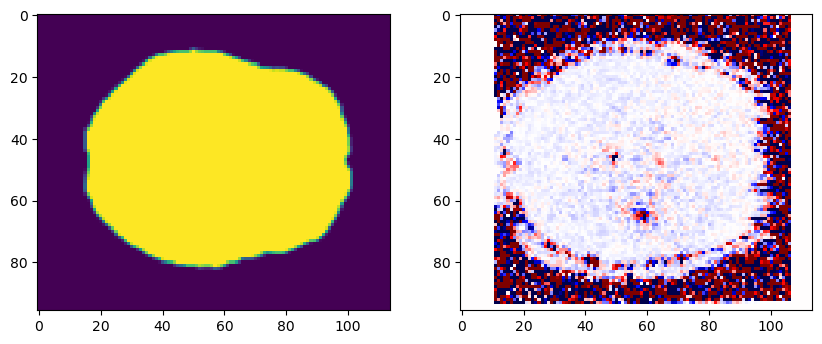

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

axs[0].imshow(wmask_nii.get_fdata()[:, :, 40])
axs[1].imshow(dphi_nii.get_fdata()[:, :, 40, 20], vmin=-2, vmax=2, cmap='seismic')

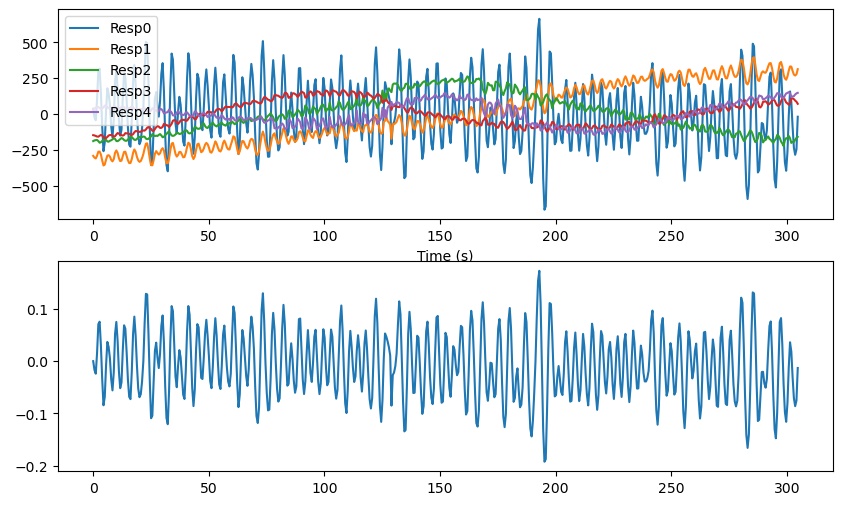

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

respwave.plot(x='Time (s)', y=['Resp0', 'Resp1', 'Resp2', 'Resp3', 'Resp4'], ax=axs[0])
axs[1].plot(t_s, mean_dphi)

plt.show()